In [1]:
import matplotlib.pyplot as plt
import numpy as np
from nuance.utils import periodic_transit, tv_dv
import numpy as np
import tinygp
import jax
jax.config.update("jax_enable_x64", True)

/Users/lgrcia/code/dev/nuance/nuance/nuance.py:14: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


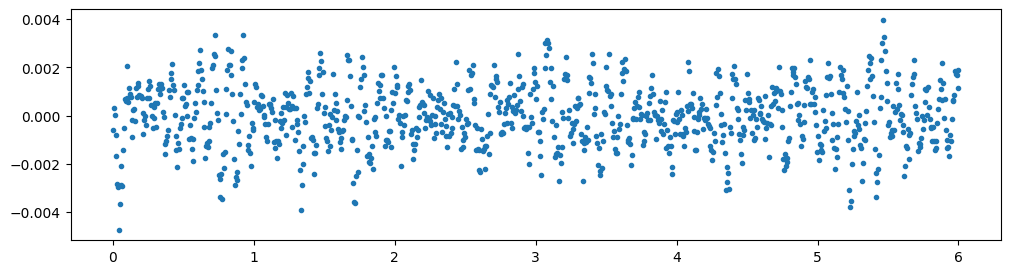

In [2]:
time = np.linspace(0, 6, 1000)
error = 0.0005
X = np.vander(time, N=4, increasing=True)
w = [1., 0.05, -0.2, -0.5]
true_period = 1.3
duration, depth = 0.05, 0.002
true_transit = depth*periodic_transit(time, 0.2/4, duration, P=true_period)
kernel = tinygp.kernels.quasisep.SHO(np.pi/duration, 5., depth/2)
gp = tinygp.GaussianProcess(kernel, time, diag=error**2)
vari = gp.sample(jax.random.PRNGKey(40))
diff_flux = true_transit + vari#+ X@w

plt.figure(None, (12, 3))
plt.plot(time, diff_flux, ".")

## Single transit (linear) search

In [3]:
from nuance import Nuance
from tinygp import kernels, GaussianProcess

nu = Nuance(time, diff_flux, X=X.T, gp=gp)

t0s = time.copy()
Ds = np.linspace(0.01, 0.1, 10)
nu.linear_search(t0s, Ds)

100%|██████████| 1000/1000 [00:00<00:00, 1698.05it/s]


## Periodic search

In [4]:
periods = np.linspace(.1, 5., 2000)
search = nu.periodic_search(periods)

100%|██████████| 2000/2000 [00:01<00:00, 1278.95it/s]


In [5]:
t0, D, P = search.best

print(f"""t0: {t0:.2f}
duration: {D:.2f}
period: {P:.3f}
depth: {nu.depth(t0, D, P)[0]:1.2e}
SNR: {nu.snr(t0, D, P):.2f}""")

t0: 0.05
duration: 0.05
period: 1.299
depth: 2.08e-03
SNR: 9.69


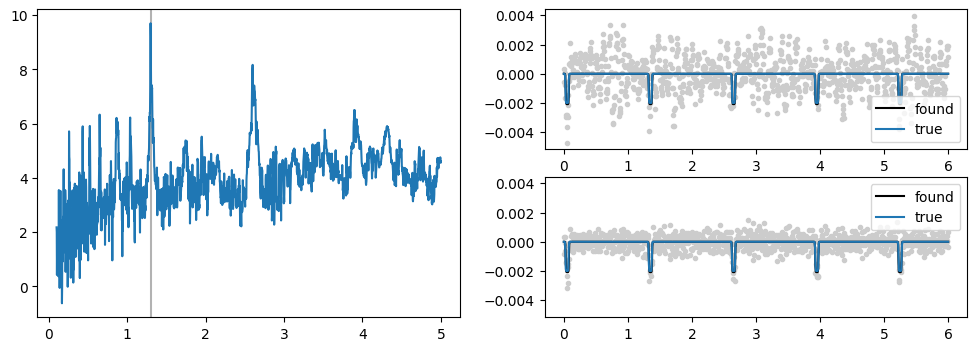

In [6]:
plt.figure(None, (12, 4))

plt.subplot(2, 2, (1, 3))
plt.axvline(true_period, c="k", alpha=0.3)
plt.plot(periods, search.Q_snr)

mean, astro, noise = nu.models(t0, D, P)

plt.subplot(2, 2, 2)
plt.plot(time, diff_flux, ".", c="0.8")
plt.plot(time, astro, c="k", label="found")
plt.plot(time, true_transit, c="C0", label="true")
ylim = plt.ylim()
_ = plt.legend()

plt.subplot(2, 2, 4)
plt.plot(time, diff_flux-noise-mean, ".", c="0.8")
plt.plot(time, astro, c="k", label="found")
plt.plot(time, true_transit, c="C0", label="true")
plt.ylim(ylim)
_ = plt.legend()